Let's first look at the distances between all of the neighboring squares

In [40]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row)):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

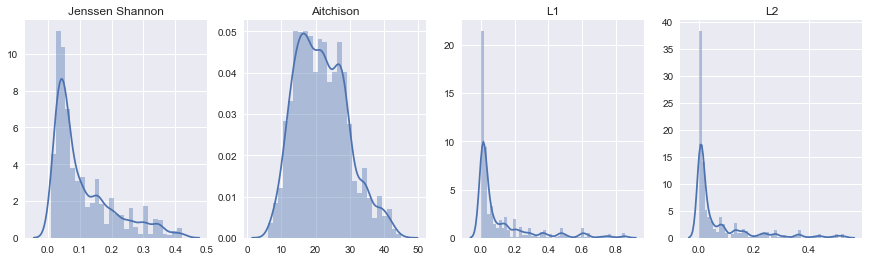

In [41]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

jsd_distances = np.array([jsd_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(jsd_distances, ax=axes[0])
axes[0].set_title('Jenssen Shannon')

aitchison_distances = np.array([aitchison_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(aitchison_distances, ax=axes[1])
axes[1].set_title('Aitchison')
    
L1_distances = np.array([L1_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L1_distances, ax=axes[2])
axes[2].set_title('L1')

L2_distances = np.array([L2_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L2_distances, ax=axes[3])
axes[3].set_title('L2')

Now, we will be only analyzing rows 5 through 13 -- we will want to only look at cross sections of the cheese that cut through the microbial gradients (i.e. we don't want rows with just rind).

Finally, let's extract the distances.  We'll only focus on the distances starting at column E, since it is in the middle of the cheese.  

In [42]:
# extract rows 5 through 13
idx = np.logical_and(metadata['grid_row'] > 5, metadata['grid_row'] < 13)
metadata = metadata.loc[idx]

# match up the rows of the metadata and the OTU table to make sure that they are in the same order
table, metadata = match(table, metadata)

Now we'll plot each row separately as its own color.

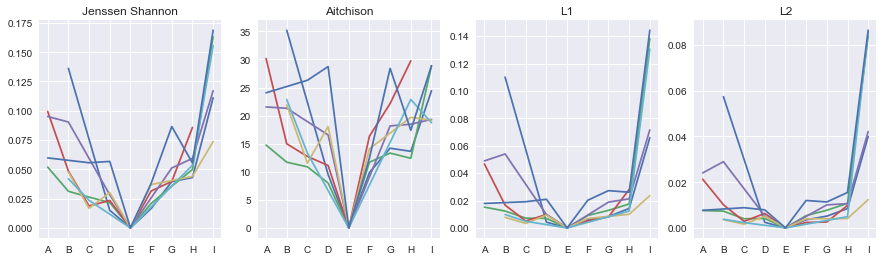

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[0].plot(md.grid_column, jsd_dm.loc[n, md.index], label='row_%s' % n)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_title('Jenssen Shannon')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[1].plot(md.grid_column, aitchison_dm.loc[n, md.index], label='row_%s' % n)    
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_title('Aitchison')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[2].plot(md.grid_column, L1_dm.loc[n, md.index], label='row_%s' % n)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].set_title('L1')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[3].plot(md.grid_column, L2_dm.loc[n, md.index], label='row_%s' % n)
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(labels)
    axes[3].set_title('L2')


The property distinguishes the Aitchison distance from the other distance metrics is known as subcompositional coherence.  This property is given as follows

$d(x_s, y_s) \leq d(x, y)$

For some indexing vector $s$ that chooses a subcomposition of $x$ and $y$.
Basically what this says is that when you calculating the distance between $x$ and $y$, if you only consider a smaller subspace with fewer dimensions, then the distance betwee the subcomponents of $x$ and $y$ will be smaller.

Let's perform some bootstraps to further investigate this.  We'll bootstrap the samples and compute the means of the distances.

In [12]:
from numpy.random import choice

# Scaling function
def scaling_function(f, x, y, k=100, N=10000):
    ds = np.zeros(k)
    for i in range(k):
        xs = choice(x, size=N)
        ys = choice(y, size=N)
        ds[i] = f(xs, ys)
    return ds.mean()

Now we will calculate the pairwise distances.  Note that the distance now aren't guaranteed to be symmetric (since the are now just expectations).

In [13]:
from skbio.stats.distance import DissimilarityMatrix

jsd_scaled = lambda x, y: scaling_function(jsd, x, y)
L1_scaled = lambda x, y: scaling_function(L1, x, y)
L2_scaled = lambda x, y: scaling_function(L2, x, y)
aitchison_scaled = lambda x, y: scaling_function(aitchison, x, y)

jsd_dm = DissimilarityMatrix.from_iterable(closure(table.values), jsd_scaled)
L1_dm = DissimilarityMatrix.from_iterable(closure(table.values), L1_scaled)
L2_dm = DissimilarityMatrix.from_iterable(closure(table.values), L2_scaled)
aitchison_dm = DissimilarityMatrix.from_iterable(table.values, aitchison_scaled)

jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)
L1_dm = pd.DataFrame(L1_dm.data, index=table.index, columns=table.index)
L2_dm = pd.DataFrame(L2_dm.data, index=table.index, columns=table.index)
aitchison_dm = pd.DataFrame(aitchison_dm.data, index=table.index, columns=table.index)

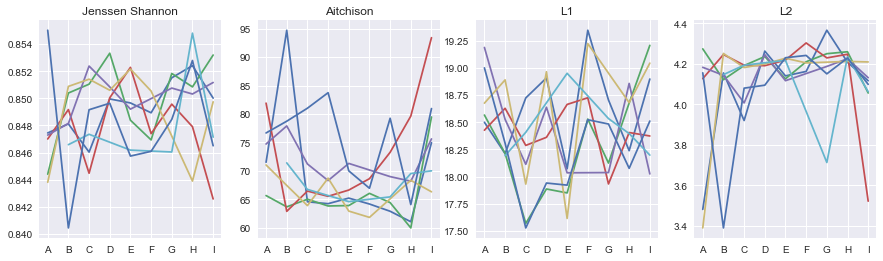

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[0].plot(md.grid_column, jsd_dm.loc[n, md.index], label='row_%s' % n)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_title('Jenssen Shannon')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[1].plot(md.grid_column, aitchison_dm.loc[n, md.index], label='row_%s' % n)    
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_title('Aitchison')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[2].plot(md.grid_column, L1_dm.loc[n, md.index], label='row_%s' % n)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].set_title('L1')
for name, md in metadata.groupby('grid_row'):
    md = md.sort_values('grid_column')
    n = md.loc[md.grid_column==4].index[0]
    axes[3].plot(md.grid_column, L2_dm.loc[n, md.index], label='row_%s' % n)
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(labels)
    axes[3].set_title('L2')

In [15]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row)):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

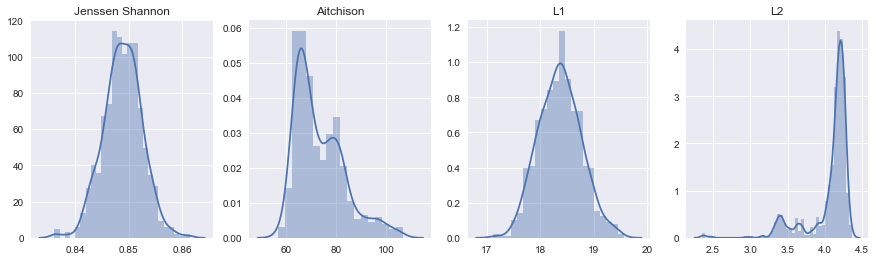

In [16]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

jsd_distances = np.array([jsd_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(jsd_distances, ax=axes[0])
axes[0].set_title('Jenssen Shannon')

aitchison_distances = np.array([aitchison_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(aitchison_distances, ax=axes[1])
axes[1].set_title('Aitchison')
    
L1_distances = np.array([L1_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L1_distances, ax=axes[2])
axes[2].set_title('L1')

L2_distances = np.array([L2_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L2_distances, ax=axes[3])
axes[3].set_title('L2')

In [17]:
from skbio.stats import subsample_counts
# Scaling function
def scaling_function(f, x, y, k=100, N=10000):
    ds = np.zeros(k)
    for i in range(k):
        xs = subsample_counts(x, N, replace=True)
        ys = subsample_counts(y, N, replace=True)
        ds[i] = f(xs, ys)
    return ds

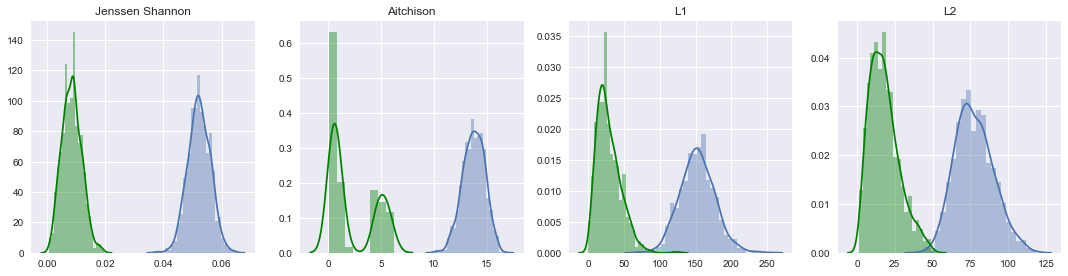

In [18]:
table = table.astype(np.int)
jsd_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                             y=table.loc['bonde.E7'], k=1000) 
L1_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
L2_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
aitchison_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                   y=table.loc['bonde.E7'], k=1000)

jsd_same_boots = scaling_function(jsd, x=table.loc['bonde.E7'], 
                                  y=table.loc['bonde.E7'], k=1000) 
L1_same_boots = scaling_function(L1, x=table.loc['bonde.E7'], 
                                 y=table.loc['bonde.E7'], k=1000)
L2_same_boots = scaling_function(L2, x=table.loc['bonde.E7'], 
                                 y=table.loc['bonde.E7'], k=1000)
aitchison_same_boots = scaling_function(aitchison, x=table.loc['bonde.E7'],
                                        y=table.loc['bonde.E7'], k=1000)

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

sns.distplot(jsd_boots, ax=axes[0])
sns.distplot(jsd_same_boots, ax=axes[0], color='green')
axes[0].set_title('Jenssen Shannon')
sns.distplot(aitchison_boots, ax=axes[1])
sns.distplot(aitchison_same_boots, ax=axes[1], color='green')
axes[1].set_title('Aitchison')
    
sns.distplot(L1_boots, ax=axes[2])
sns.distplot(L1_same_boots, ax=axes[2], color='green')
axes[2].set_title('L1')

sns.distplot(L2_boots, ax=axes[3])
sns.distplot(L2_same_boots, ax=axes[3], color='green')
axes[3].set_title('L2')
plt.tight_layout()


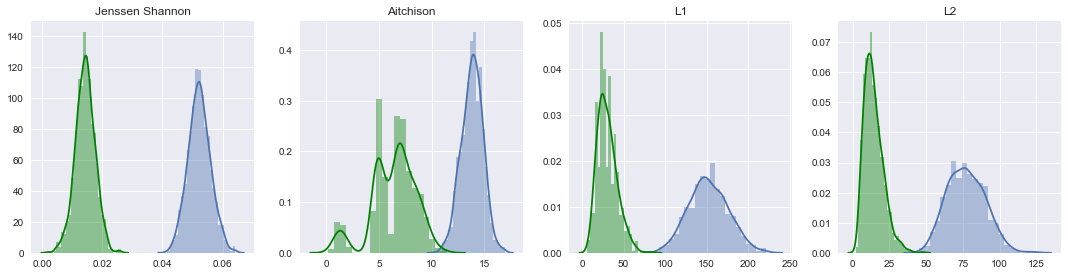

In [19]:
jsd_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                             y=table.loc['bonde.E7'], k=1000) 
L1_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
L2_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                            y=table.loc['bonde.E7'], k=1000)
aitchison_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                   y=table.loc['bonde.E7'], k=1000)

jsd_same_boots = scaling_function(jsd, x=table.loc['bonde.A7'], 
                                  y=table.loc['bonde.A7'], k=1000) 
L1_same_boots = scaling_function(L1, x=table.loc['bonde.A7'], 
                                 y=table.loc['bonde.A7'], k=1000)
L2_same_boots = scaling_function(L2, x=table.loc['bonde.A7'], 
                                 y=table.loc['bonde.A7'], k=1000)
aitchison_same_boots = scaling_function(aitchison, x=table.loc['bonde.A7'],
                                        y=table.loc['bonde.A7'], k=1000)

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

sns.distplot(jsd_boots, ax=axes[0])
sns.distplot(jsd_same_boots, ax=axes[0], color='green')
axes[0].set_title('Jenssen Shannon')
sns.distplot(aitchison_boots, ax=axes[1])
sns.distplot(aitchison_same_boots, ax=axes[1], color='green')
axes[1].set_title('Aitchison')
    
sns.distplot(L1_boots, ax=axes[2])
sns.distplot(L1_same_boots, ax=axes[2], color='green')
axes[2].set_title('L1')

sns.distplot(L2_boots, ax=axes[3])
sns.distplot(L2_same_boots, ax=axes[3], color='green')
axes[3].set_title('L2')
plt.tight_layout()

# Effect size from bootstraps

This will calculate the effect size from the pairs for the boostraps

In [51]:
from skbio.stats import subsample_counts
from itertools import product

# Scaling function
def scaling_function(f, x, y, k=10, N=1000):
    ds = np.zeros(k)
    xs = np.zeros((k, len(x)))
    ys = np.zeros((k, len(y)))
    for i in range(k):
        xs[i, :] = subsample_counts(x, N, replace=True)
        ys[i, :] = subsample_counts(y, N, replace=True)

    x_pairs = [f(xs[i, :], xs[j, :]) for i, j in product(range(k), range(k))]
    y_pairs = [f(ys[i, :], ys[j, :]) for i, j in product(range(k), range(k))]
    xy_pairs = [f(xs[i, :], ys[j, :]) for i, j in product(range(k), range(k))]
    x_std = np.std(x_pairs)
    y_std = np.std(y_pairs)
    return np.mean(xy_pairs) / np.min((x_std, y_std))

In [52]:
from skbio.stats.distance import DissimilarityMatrix
table = table.astype(np.int)

jsd_scaled = lambda x, y: scaling_function(jsd, x, y)
L1_scaled = lambda x, y: scaling_function(L1, x, y)
L2_scaled = lambda x, y: scaling_function(L2, x, y)
aitchison_scaled = lambda x, y: scaling_function(aitchison, x, y)

jsd_dm = DissimilarityMatrix.from_iterable(table.values, jsd_scaled)
L1_dm = DissimilarityMatrix.from_iterable(table.values, L1_scaled)
L2_dm = DissimilarityMatrix.from_iterable(table.values, L2_scaled)
aitchison_dm = DissimilarityMatrix.from_iterable(table.values, aitchison_scaled)

jsd_dm = pd.DataFrame(jsd_dm.data, index=table.index, columns=table.index)
L1_dm = pd.DataFrame(L1_dm.data, index=table.index, columns=table.index)
L2_dm = pd.DataFrame(L2_dm.data, index=table.index, columns=table.index)
aitchison_dm = pd.DataFrame(aitchison_dm.data, index=table.index, columns=table.index)

In [58]:
pairs = []
for i in range(len(metadata)):
    for j in range(len(metadata)):
        x = metadata.iloc[i]
        y = metadata.iloc[j]
        if (abs(x.grid_column - y.grid_column) < 2 and 
            abs(x.grid_row - y.grid_row)):
            pairs.append((x.name, y.name))
pairs = pd.DataFrame(pairs, columns=['source', 'sink'])

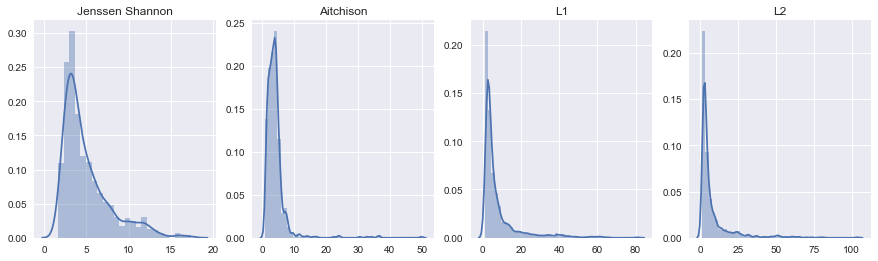

In [60]:
import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))

jsd_distances = np.array([jsd_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(jsd_distances, ax=axes[0])
axes[0].set_title('Jenssen Shannon')

aitchison_distances = np.array([aitchison_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(aitchison_distances, ax=axes[1])
axes[1].set_title('Aitchison')
    
L1_distances = np.array([L1_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L1_distances, ax=axes[2])
axes[2].set_title('L1')

L2_distances = np.array([L2_dm.loc[pairs.loc[p, 'source'], pairs.loc[p, 'sink']] for p in pairs.index])
sns.distplot(L2_distances, ax=axes[3])
axes[3].set_title('L2')

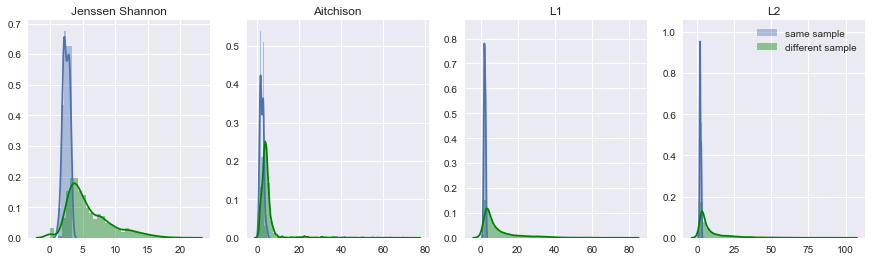

In [77]:

import seaborn as sns
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
labels = list('ABCDEFGHI')
x = np.arange(len(labels))
k = len(jsd_dm.columns)

jsd_same_bin = [jsd_dm.loc[i, i] for i in jsd_dm.columns]
jsd_diff_bin = [jsd_dm.iloc[i, j] if i!=j else 0 for i,j in product(range(k), range(k))]
sns.distplot(jsd_same_bin, ax=axes[0])
sns.distplot(jsd_diff_bin, ax=axes[0], color='green')
axes[0].set_title('Jenssen Shannon')

aitchison_same_bin = [aitchison_dm.loc[i, i] for i in aitchison_dm.columns]
aitchison_diff_bin = [aitchison_dm.iloc[i, j] if i!=j else 0 for i,j in product(range(k), range(k))]
sns.distplot(aitchison_same_bin, ax=axes[1])
sns.distplot(aitchison_diff_bin, ax=axes[1], color='green')
axes[1].set_title('Aitchison')

L1_same_bin = [L1_dm.loc[i, i] for i in L1_dm.columns]
L1_diff_bin = [L1_dm.iloc[i, j] if i!=j else 0 for i,j in product(range(k), range(k))]
sns.distplot(L1_same_bin, ax=axes[2])
sns.distplot(L1_diff_bin, ax=axes[2], color='green')
axes[2].set_title('L1')

L2_same_bin = [L2_dm.loc[i, i] for i in L2_dm.columns]
L2_diff_bin = [L2_dm.iloc[i, j] if i!=j else 0 for i,j in product(range(k), range(k))]
sns.distplot(L2_same_bin, ax=axes[3], label='same sample')
sns.distplot(L2_diff_bin, ax=axes[3], color='green', label='different sample')
axes[3].set_title('L2')
axes[3].legend()